# Exploring the Statistics of Milk Production

## Background

The dairy industry is awash with metrics used to help dairy farmers more efficiently produce more significant volumes of milk for consumption in milk, cheese, butter and other consumable products.  Looking specifically to a small herd of cattle in Pennsylvania, this analysis explores some relationships in the available data.

The collected data is from a single herd of dairy cattle.  The lactating portion of the herd is milked twice daily.  Animals who are in a dry period are not actively producing milk and are not included on those dates.  This analysis examines the relationships between milk production, weather, and numerical ratings of given animals.  We will focus exclusively on the 2016 calendar year. 

## Selected Terms

The following terms and definitions should be useful for understanding the contents of this analysis.  

- **Milk Weight:** The amount of milk produced by an animal.  Measured in pounds of milk. For reference, a gallon of milk weighs approximately 8.6 pounds.

- **Dry Period:** The period when a cow is not producing milk. Often serves as a time of rest following a lactation period.

- **Lactation Period:** The period when a cow is producing milk.

- **Days in Milk:** The number of consecutive days a given cow has been actively producing milk.

- **Linear Classification Score:** A integer score between 1-100 given to a milk cow, providing a numerical representation of how well a the physical attributes of an animal fits the profile of an 'ideal' milking cow.  A weighted summarization of 18+ assessments of a given animal.

- **Breed Age Average:** A numerical score, based on the final linear classification score.  Provides additional weighting for the breed, and age of an animal.  May exceed 100, and a higher score indicates a more 'ideal' milking cow.


## Test Hypotheses

The analysis seeks to test the following sets hypotheses:

### Test Hypothesis: Maximum Temperature and Milk Weight

- **Ho:** The maximum daily temperature is not correlated with the milk produced on a given day.
- **Ha:** The maximum daily temperature is correlated with the milk produced on a given day.

### Test Hypothesis: Breed Age Average and Milk Weight

- **Ho:** The breed age average score is not linearly correlated with the total milk weight produced by a given dairy cow in 2016.
- **Ha:** The breed age average score is linearly correlated with the average annual milk weight produced by a given dairy cow in 2016.

## Findings

### Test Hypothesis: Breed Age Average and Milk Weight

The breed age average score was found to be positively correlated with the average annual milk weight produced by a given dairy cow in 2016.  The correlation was found to be statistically significant.

### Test Hypothesis: Maximum Temperature and Milk Weight

No statistically significant linear correlation was found between max temperature and weekly milk production.

## Future Considerations

- Investigate the correlation between individual components of a linear classification score and milk production.
- Investigate the fit of higher order polynomials to relationship between maximum temperature and milk production.

## Data Preparation: Retrieval

In [1]:
import sys
sys.path.insert(0, '../scripts')
sys.path.insert(0, '../data/database')
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
engine =  create_engine('sqlite:///../data/database/happycows.db')
with engine.connect() as con:
    milk_volumes = pd.read_sql_table('milk_volume', con)
    weather = pd.read_sql_table('weather', con)
    classification = pd.read_sql_table('classification', con)
sns.set()

## Data Preparation: Milk Volumes

In [3]:
m2016 = milk_volumes.set_index(['date'])['2016-01-01':'2016-12-31']

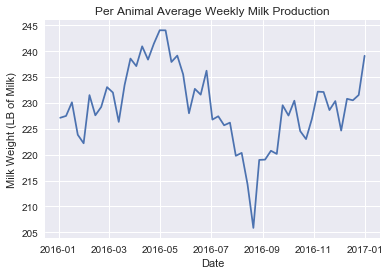

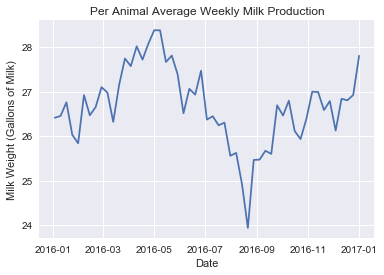

In [4]:
def transform_data_for_weekly_average(data):
    """Average Milk Weight produced per animal per week assuming a full 7 day week"""
    data['milking_count'] = 1
    data = data.resample('W').sum()
    data = data[['milk_weight', 'milking_count']]
    data['milk_weight'] = (data['milk_weight'] / data['milking_count']) * 14
    return data

m2016_weekly_average = transform_data_for_weekly_average(m2016)
_ = plt.plot(m2016_weekly_average['milk_weight'])
_ = plt.ylabel("Milk Weight (LB of Milk)")
_ = plt.xlabel("Date")
_ = plt.title("Per Animal Average Weekly Milk Production")
plt.show()

_ = plt.plot(m2016_weekly_average['milk_weight'] / 8.6)
_ = plt.ylabel("Milk Weight (Gallons of Milk)")
_ = plt.xlabel("Date")
_ = plt.title("Per Animal Average Weekly Milk Production")
plt.show()

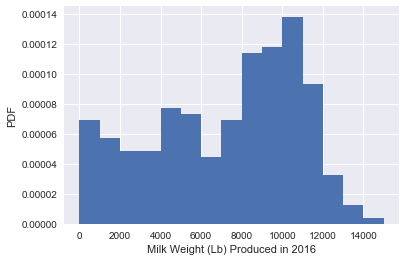

In [5]:
# Total Milk Produced Per Animal for 2016
def transform_data_for_per_animal_total(data):
    data = data.groupby('animal_id').resample('A').sum()['milk_weight']
    data = data.reset_index()
    return data[['animal_id', 'milk_weight']]

bins = [1000 * i for i in range(16)]
m2016_animal_total = transform_data_for_per_animal_total(m2016)
_ = plt.hist(m2016_animal_total['milk_weight'], bins=bins, normed=True)
_ = plt.xlabel("Milk Weight (Lb) Produced in 2016")
_ = plt.ylabel("PDF")
plt.show()

## Data Preparation: Weather Data

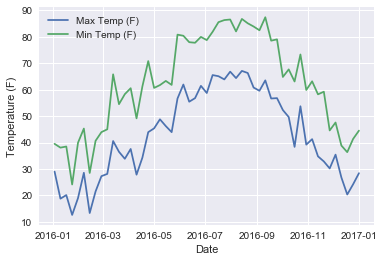

In [6]:
# Weekly average min and max temperature
def transform_weather_data(data):
    data = data.resample('W').mean()
    return data[['TMIN', 'TMAX']]

## Data Preparation: Weather
w2016 = weather.set_index(['DATE'])['2016-01-01':'2016-12-31']
w2016 = transform_weather_data(w2016)

_ = plt.plot(w2016)
_ = plt.xlabel('Date')
_ = plt.ylabel('Temperature (F)')
_ = plt.legend(['Max Temp (F)', 'Min Temp (F)'])
plt.show()

## Data Preparation: Linear Classification Scores

In [7]:
# Classification Data
def transform_classification_data(data):
    data = data[data['breed_age_average'] < 200]
    return data[['animal_id', 'final_score', 'breed_age_average', 'category']]

# Reindex to each cow and date combination
c2016 = transform_classification_data(classification)
print(c2016.head())

   animal_id  final_score  breed_age_average   category
0     1485.0         85.0         106.000000  Very Good
1     1542.0         91.0         113.500000  Excellent
2     1553.0         87.0         108.500000  Very Good
3     1622.0         88.0         109.699997  Very Good
4     1624.0         82.0         102.199997  Good Plus


## Analysis: Breed Age Average and Milk Weight

In [8]:
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""
    inds = np.arange(len(x))
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)

    return bs_slope_reps, bs_intercept_reps

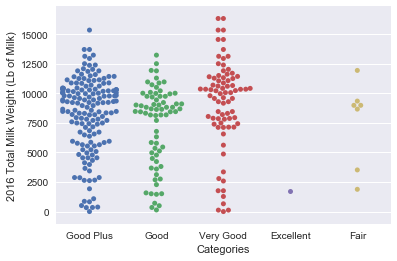

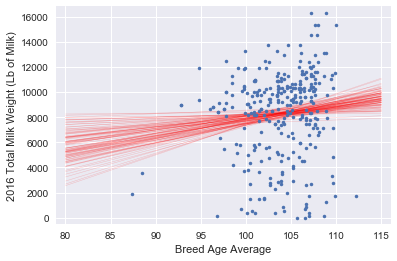

In [9]:
milk_and_baa = pd.merge(left=m2016_animal_total, right=c2016, left_on='animal_id', right_on='animal_id')
milk_and_baa = milk_and_baa.dropna(axis=0, subset=['breed_age_average', 'milk_weight'], how='any')

# Swarm Plot by Animal Categories
_ = sns.swarmplot(x='category', y='milk_weight', data=milk_and_baa)
_ = plt.xlabel('Categories')
_ = plt.ylabel('2016 Total Milk Weight (Lb of Milk)')
plt.show()

# Pairs bootstrapping and scatter plot between BAA and milk weight
bs_slopes, bs_intercepts = draw_bs_pairs_linreg(milk_and_baa['breed_age_average'], milk_and_baa['milk_weight'], 1000)

# Generate array of x-values for bootstrap lines: x
x = np.array([80, 115])

# Plot the bootstrap lines
for i in range(100):
    _ = plt.plot(x, bs_slopes[i]*x + bs_intercepts[i],
                 linewidth=0.5, alpha=0.2, color='red')

_ = plt.plot(milk_and_baa['breed_age_average'], milk_and_baa['milk_weight'], marker='.', linestyle='none')
_ = plt.margins(0.03)
_ = plt.xlabel('Breed Age Average')
_ = plt.ylabel('2016 Total Milk Weight (Lb of Milk)')
plt.show()

Given the variance in the line of best fit, we continue our analysis the Pearson Correlation Coefficient and associated p-value to see if we can reject the null hypothesis for breed age average and the total milk weight from 2016.

In [10]:
def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""
    corr_mat = np.corrcoef(x, y)
    return corr_mat[0,1]

In [11]:
def calculate_correlation_and_p_value(x, y, permutations=10000, alpha=0.05):
    obs_r = pearson_r(x, y)
    perm_replicates = np.empty(permutations)
    for i in range(permutations):
        y_permutated = np.random.permutation(y)
        perm_replicates[i] = pearson_r(x, y_permutated)
    
    p = np.sum(perm_replicates >= obs_r) / len(perm_replicates)
    
    print(f'     r = {obs_r}')
    print(f' p-val = {p}')
    print(f' alpha = {alpha}\n')
    if p < alpha:
        print("The correlation is statistically significant at this p-value and alpha level.")
    else:
        print("The correlation is not statistically significant at this p-value and alpha level.")
    
    return obs_r, p

In [12]:
r, p = calculate_correlation_and_p_value(milk_and_baa['breed_age_average'], milk_and_baa['milk_weight'])

     r = 0.11626490280022986
 p-val = 0.0185
 alpha = 0.05

The correlation is statistically significant at this p-value and alpha level.


## Conclusion: Breed Age Average and Milk Weight

With a positive correlation coefficent and a p-value < 0.05 we can reject the following null hypothesis (Ho), and infer that the paired alternative hypothesis (Ha) is true:

- ~~**Ho:** The breed age average score is not correlated with the total milk weight produced by a given dairy cow in 2016.~~
- **Ha:** The breed age average score is correlated with the average annual milk weight produced by a given dairy cow in 2016.

An animal's breed age average score was found to be positively, linearly correlated with the total milk produced in 2016.

## Analysis: Average Maximum Weekly Temperature and Weekly Average Milk Weight

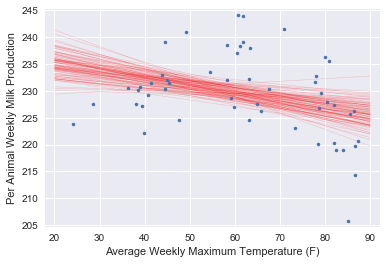

In [13]:
milk_and_temp = pd.merge(left=m2016_weekly_average.reset_index(), right=w2016.reset_index(), left_on='date', right_on='DATE')
milk_and_temp = milk_and_temp.dropna(axis=0, subset=['TMAX', 'milk_weight'], how='any')

# Pairs bootstrapping and scatter plot between BAA and milk weight
bs_slopes, bs_intercepts = draw_bs_pairs_linreg(milk_and_temp['TMAX'], milk_and_temp['milk_weight'], 1000)

# Generate array of x-values for bootstrap lines: x
x = np.array([20, 90])

# Plot the bootstrap lines
for i in range(100):
    _ = plt.plot(x, bs_slopes[i]*x + bs_intercepts[i],
                linewidth=0.5, alpha=0.2, color='red')

_ = plt.plot(milk_and_temp['TMAX'], milk_and_temp['milk_weight'], marker='.', linestyle='none')
_ = plt.margins(0.03)
_ = plt.xlabel('Average Weekly Maximum Temperature (F)')
_ = plt.ylabel('Per Animal Weekly Milk Production')
plt.show()

In [14]:
r, p = calculate_correlation_and_p_value(milk_and_temp['TMAX'], milk_and_temp['milk_weight'])

     r = -0.31220462379942315
 p-val = 0.9896
 alpha = 0.05

The correlation is not statistically significant at this p-value and alpha level.


## Conclusion: Average Maximum Weekly Temperature and Weekly Average Milk Weight

With a negative correlation coefficent and a p-value > 0.05 we cannot reject the following null hypothesis (Ho), and infer that the paired alternative hypothesis (Ha) is true:

- **Ho:** The average of weekly maximum temperatures is not linearly correlated with the milk produced in a given week.
- ~~**Ha:** The average of weekly maximum temperatures is linearly correlated with the milk produced in a given week.~~

There is not a linear relationship between temperature and maximum temperature and milk production.